
# 2/3/4 species Competitive Lotka-Volterra

Adapted from the numpyro predator-prey example
http://num.pyro.ai/en/stable/examples/ode.html


In [6]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

import arviz as az

NUM_CORES = 1
numpyro.set_host_device_count(NUM_CORES)

###   2-species

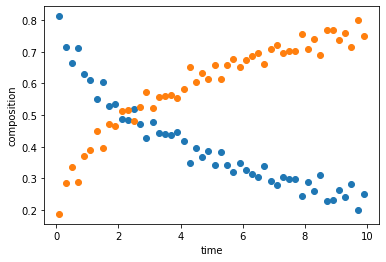

In [3]:
#Recover parameters via inference from data from mathematica simulation for 2 species:
df=pd.read_csv("../data/sim.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2]]).T

plt.scatter(week, data[:, 0])
plt.scatter(week, data[:, 1])
plt.xlabel("time")
plt.ylabel("composition")
plt.show()

In [7]:
def dz_dt(z : float, t : float, theta : float):

    z1 = z[0]
    z2 = z[1]
    a11, a12, a21, a22 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2))
    
    return jnp.stack([dz1_dt, dz2_dt])


Sloc = 0.25 # scale the location prior
Svar = 0.5 # scale the variance prior

def model(N : int, y = None):
    
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low = 0.0,
            loc = jnp.repeat(Sloc, 4),
            scale = jnp.repeat(Svar, 4),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol = 1e-5, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs=y)

    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples=500,
    num_warmup=500,
    num_chains=NUM_CORES,
    progress_bar=True,
)

mcmc.run(PRNGKey(1), N = data.shape[0], y = np.round(100 * data))
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:10<00:00, 92.21it/s, 63 steps of size 8.34e-02. acc. prob=0.83]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.37      0.19      0.34      0.08      0.64     88.12      1.00
  theta[1]      0.54      0.20      0.53      0.19      0.82    132.37      1.01
  theta[2]      0.33      0.17      0.30      0.07      0.58     94.36      1.00
  theta[3]      0.53      0.17      0.53      0.23      0.78    132.82      1.01
 z_init[0]      3.29      0.83      3.18      2.05      4.67    102.30      1.00
 z_init[1]      1.73      0.75      1.58      0.63      2.81     93.64      1.00

Number of divergences: 5


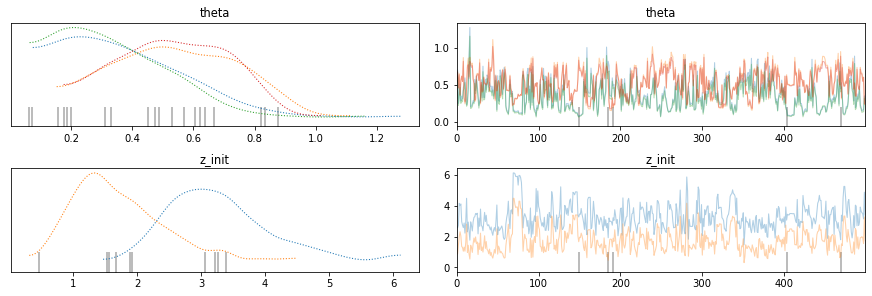

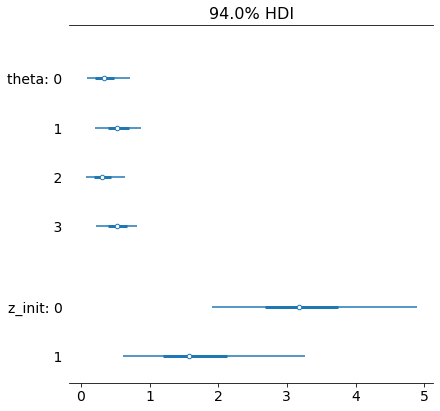

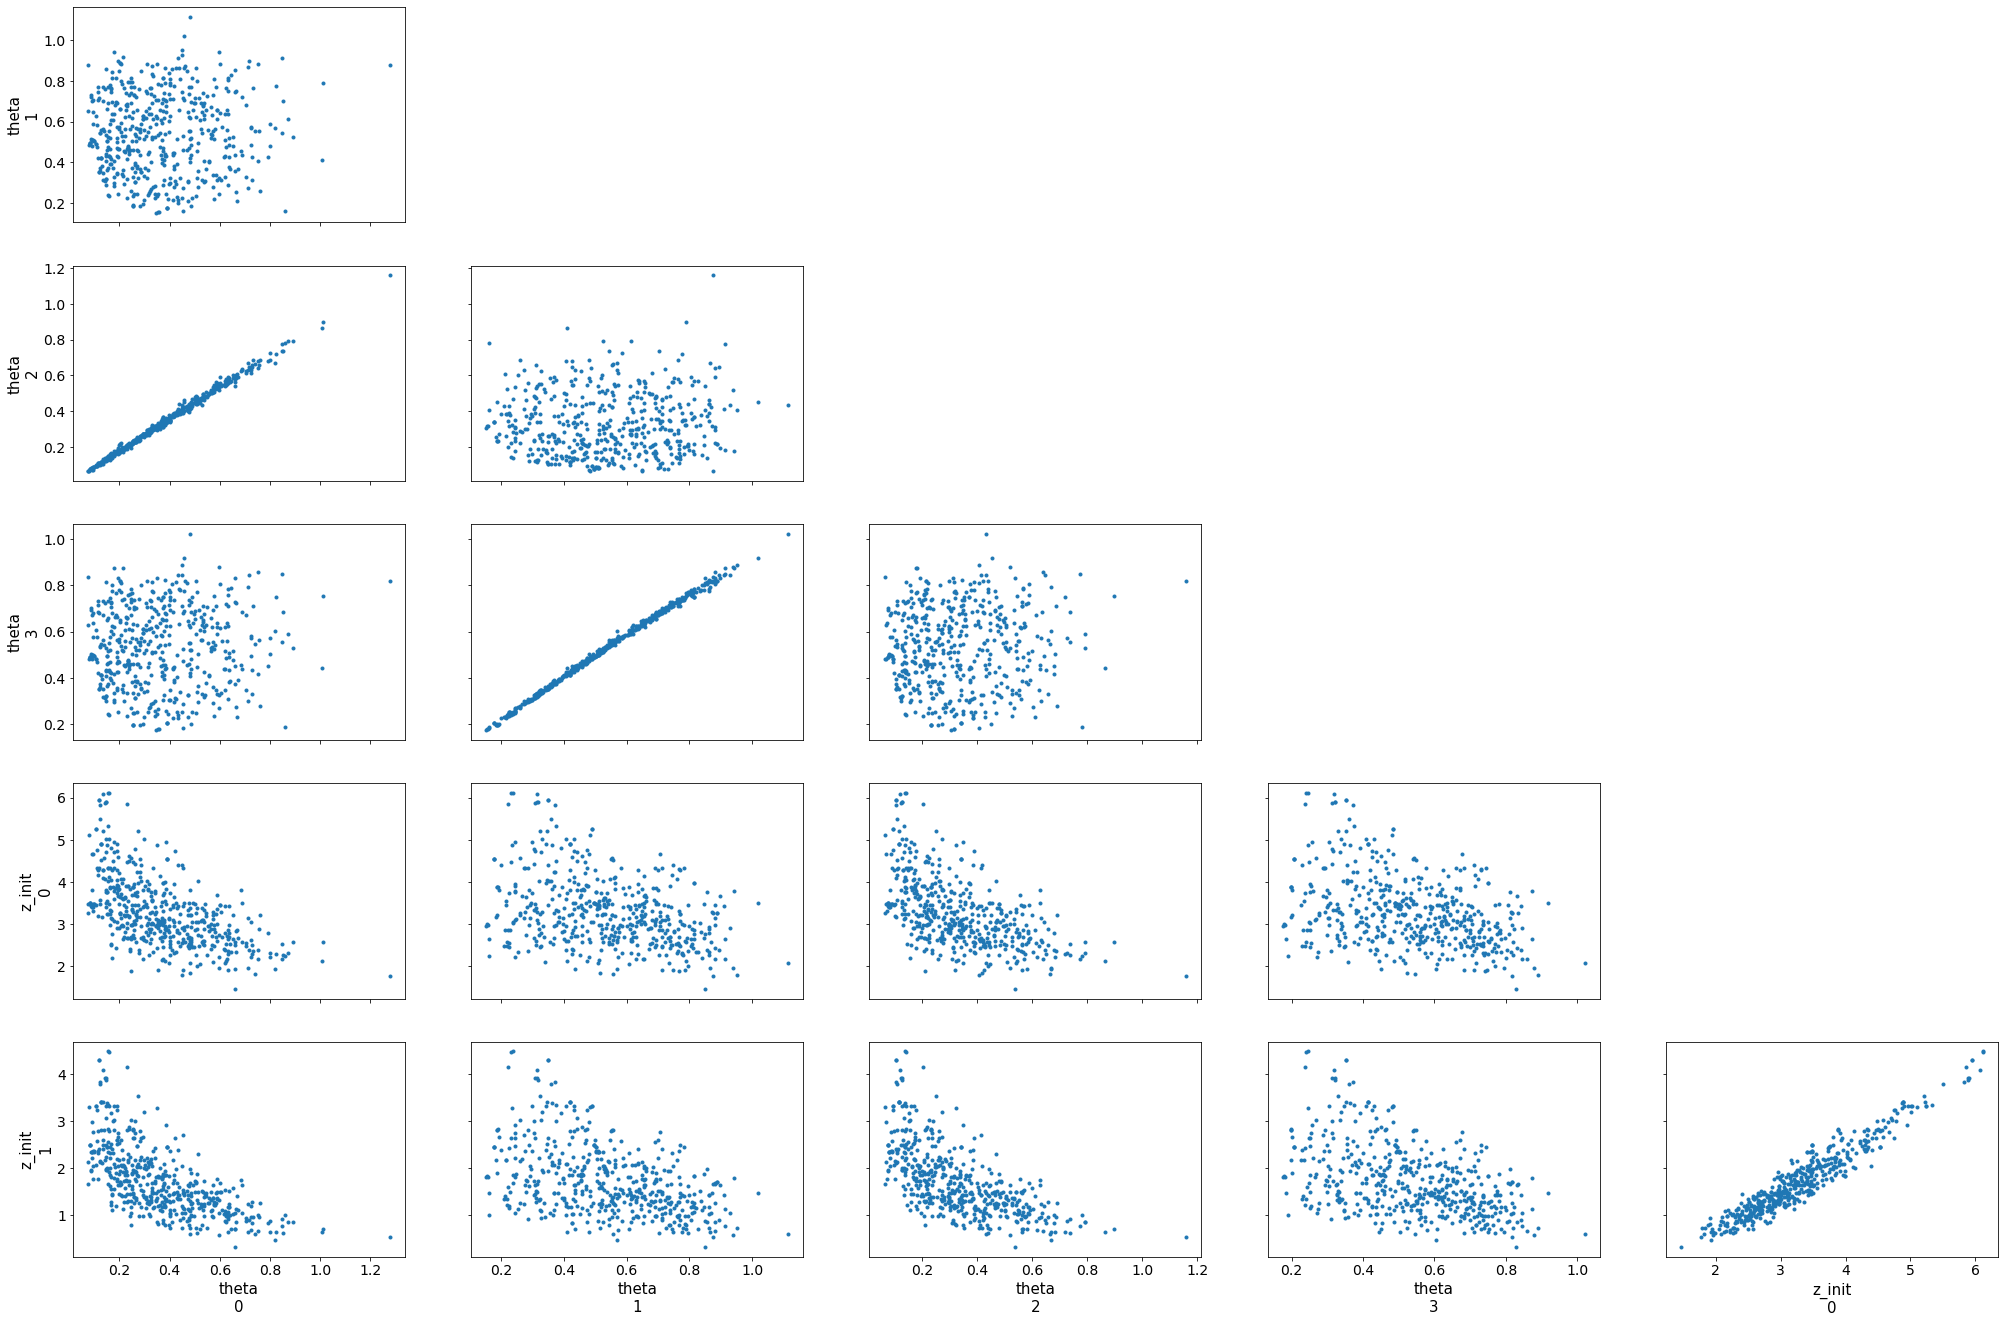

In [8]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()


az.plot_forest(az.from_numpyro(mcmc), combined = True)
# plt.vlines(0, 0, 100)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

In [9]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

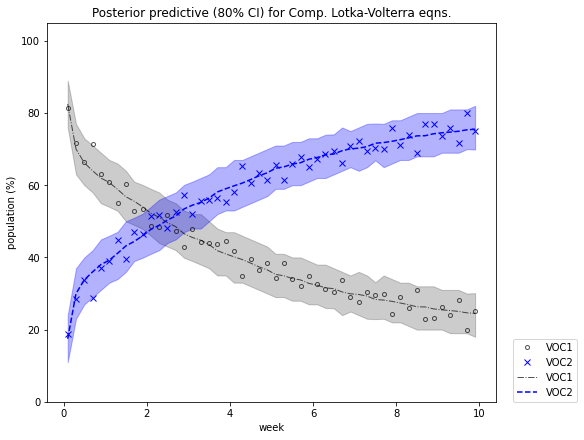

In [10]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, 100 * data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, 100 * data[:, 1], "bx", label="VOC2")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week,  mu[:, 1], "b--", label="VOC2")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

### 3-species

In [16]:
df = pd.read_csv("../data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

trans_data =  np.round(100 *data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
trans_data[:5]

array([[75.,  7., 18.],
       [67., 13., 20.],
       [59.,  8., 33.],
       [50., 12., 38.],
       [44., 12., 44.]])

In [17]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior

def dz_dt(z : float, t : float, theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N : int, y = None):
    
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low = 0.0,
            loc = jnp.repeat(Sloc, 12),
            scale = jnp.repeat(Svar, 12),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=NUM_CORES,
    progress_bar=True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()



  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:08<2:19:03,  8.35s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 33/1000 [00:08<1:34:14,  5.85s/it, 63 steps of size 7.58e-04. acc. prob=0.69]

warmup:   4%|▍         | 43/1000 [00:09<1:05:51,  4.13s/it, 1023 steps of size 2.74e-03. acc. prob=0.72]

warmup:   5%|▌         | 50/1000 [00:10<46:28,  2.94s/it, 1023 steps of size 9.07e-04. acc. prob=0.72]  

warmup:   6%|▌         | 56/1000 [00:11<33:09,  2.11s/it, 1023 steps of size 2.09e-03. acc. prob=0.73]

warmup:   6%|▌         | 60/1000 [00:12<23:39,  1.51s/it, 1023 steps of size 1.73e-03. acc. prob=0.73]

warmup:   6%|▋         | 63/1000 [00:12<17:19,  1.11s/it, 1023 steps of size 1.13e-03. acc. prob=0.73]

warmup:   7%|▋         | 66/1000 [00:13<12:53,  1.21it/s, 1023 steps of size 6.62e-04. acc. prob=0.73]

warmup:   7%|▋         | 68/1000 [00:13<09:51,  1.58it/s, 1023 steps of size 1.49e-03. acc. prob=0.74]

warmup:   7%|▋    

warmup:  17%|█▋        | 170/1000 [00:26<01:43,  8.03it/s, 1023 steps of size 5.21e-03. acc. prob=0.76]

warmup:  17%|█▋        | 171/1000 [00:26<01:55,  7.15it/s, 1023 steps of size 8.48e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [00:26<02:04,  6.67it/s, 1023 steps of size 1.28e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [00:27<01:53,  7.30it/s, 1023 steps of size 9.29e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [00:27<01:40,  8.19it/s, 511 steps of size 2.41e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [00:27<01:27,  9.34it/s, 1023 steps of size 7.51e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [00:27<01:29,  9.19it/s, 319 steps of size 1.47e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 182/1000 [00:27<01:44,  7.86it/s, 1023 steps of size 1.74e-03. acc. prob=0.76]

warmup:  18%|█▊        | 183/1000 [00:28<01:54,  7.11it/s, 1023 steps of size 3.01e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [00:28<02:02,  6.65it

warmup:  28%|██▊       | 278/1000 [00:40<01:39,  7.28it/s, 1023 steps of size 7.61e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [00:40<01:46,  6.76it/s, 1023 steps of size 1.21e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [00:40<01:28,  8.08it/s, 1023 steps of size 4.45e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [00:41<01:38,  7.26it/s, 1023 steps of size 7.56e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [00:41<01:46,  6.71it/s, 1023 steps of size 1.24e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [00:41<01:37,  7.29it/s, 1023 steps of size 7.47e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [00:41<01:38,  7.21it/s, 767 steps of size 5.64e-03. acc. prob=0.77] 

warmup:  29%|██▉       | 288/1000 [00:41<01:45,  6.76it/s, 1023 steps of size 8.57e-03. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [00:41<01:22,  8.60it/s, 255 steps of size 4.12e-03. acc. prob=0.77] 

warmup:  29%|██▉       | 293/1000 [00:42<01:35,  7.39it

warmup:  43%|████▎     | 428/1000 [00:55<00:51, 11.18it/s, 159 steps of size 1.02e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [00:55<00:45, 12.66it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [00:55<00:35, 15.76it/s, 93 steps of size 1.47e-02. acc. prob=0.78] 

warmup:  44%|████▍     | 438/1000 [00:55<00:29, 18.90it/s, 127 steps of size 7.67e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [00:55<00:37, 14.91it/s, 511 steps of size 5.45e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [00:56<00:43, 12.85it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [00:56<00:44, 12.43it/s, 511 steps of size 8.71e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [00:56<00:45, 12.21it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [00:56<00:37, 14.79it/s, 248 steps of size 1.88e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [00:56<00:35, 15.44it/s, 1023 

sample:  60%|█████▉    | 596/1000 [01:08<00:28, 14.36it/s, 255 steps of size 9.11e-03. acc. prob=0.78]

sample:  60%|█████▉    | 598/1000 [01:08<00:33, 12.10it/s, 767 steps of size 9.11e-03. acc. prob=0.78]

sample:  60%|██████    | 600/1000 [01:08<00:31, 12.89it/s, 255 steps of size 9.11e-03. acc. prob=0.78]

sample:  60%|██████    | 602/1000 [01:08<00:29, 13.56it/s, 511 steps of size 9.11e-03. acc. prob=0.76]

sample:  60%|██████    | 604/1000 [01:08<00:38, 10.35it/s, 1023 steps of size 9.11e-03. acc. prob=0.76]

sample:  61%|██████    | 606/1000 [01:08<00:36, 10.71it/s, 511 steps of size 9.11e-03. acc. prob=0.75] 

sample:  61%|██████    | 608/1000 [01:09<00:36, 10.61it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  61%|██████    | 610/1000 [01:09<00:34, 11.41it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  61%|██████    | 612/1000 [01:09<00:31, 12.27it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  61%|██████▏   | 614/1000 [01:09<00:29, 13.05it/s, 511

sample:  76%|███████▌  | 758/1000 [01:20<00:17, 13.55it/s, 255 steps of size 9.11e-03. acc. prob=0.75]

sample:  76%|███████▌  | 760/1000 [01:20<00:17, 14.05it/s, 255 steps of size 9.11e-03. acc. prob=0.75]

sample:  76%|███████▌  | 762/1000 [01:20<00:19, 12.23it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  76%|███████▋  | 764/1000 [01:20<00:20, 11.72it/s, 255 steps of size 9.11e-03. acc. prob=0.75]

sample:  77%|███████▋  | 766/1000 [01:21<00:18, 12.97it/s, 399 steps of size 9.11e-03. acc. prob=0.75]

sample:  77%|███████▋  | 768/1000 [01:21<00:17, 13.57it/s, 255 steps of size 9.11e-03. acc. prob=0.75]

sample:  77%|███████▋  | 770/1000 [01:21<00:16, 13.92it/s, 255 steps of size 9.11e-03. acc. prob=0.75]

sample:  77%|███████▋  | 772/1000 [01:21<00:14, 15.23it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  77%|███████▋  | 774/1000 [01:21<00:15, 14.43it/s, 395 steps of size 9.11e-03. acc. prob=0.75]

sample:  78%|███████▊  | 777/1000 [01:21<00:13, 16.03it/s, 383 s

sample:  91%|█████████ | 911/1000 [01:32<00:08, 10.20it/s, 511 steps of size 9.11e-03. acc. prob=0.75] 

sample:  91%|█████████▏| 913/1000 [01:33<00:08,  9.80it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  92%|█████████▏| 915/1000 [01:33<00:08,  9.67it/s, 1023 steps of size 9.11e-03. acc. prob=0.75]

sample:  92%|█████████▏| 917/1000 [01:33<00:08, 10.18it/s, 511 steps of size 9.11e-03. acc. prob=0.75] 

sample:  92%|█████████▏| 919/1000 [01:33<00:07, 10.56it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  92%|█████████▏| 921/1000 [01:33<00:07, 10.89it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  92%|█████████▏| 923/1000 [01:34<00:06, 11.11it/s, 511 steps of size 9.11e-03. acc. prob=0.75]

sample:  92%|█████████▎| 925/1000 [01:34<00:06, 12.12it/s, 255 steps of size 9.11e-03. acc. prob=0.76]

sample:  93%|█████████▎| 928/1000 [01:34<00:05, 13.52it/s, 511 steps of size 9.11e-03. acc. prob=0.76]

sample:  93%|█████████▎| 930/1000 [01:34<00:04, 14.88it/s, 89


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.01      0.00      0.00      0.00      0.01    108.27      1.00
  theta[1]      0.01      0.01      0.01      0.00      0.02    145.35      1.02
  theta[2]      0.01      0.01      0.01      0.00      0.02    245.15      1.00
  theta[3]      0.01      0.01      0.01      0.00      0.02    303.67      1.01
  theta[4]      0.00      0.00      0.00      0.00      0.01    146.63      1.00
  theta[5]      0.03      0.01      0.03      0.02      0.04    105.57      1.02
  theta[6]      0.02      0.01      0.02      0.01      0.03    128.30      1.01
  theta[7]      0.01      0.00      0.00      0.00      0.01    133.79      1.02
  theta[8]      0.04      0.01      0.04      0.03      0.05    157.87      1.01
  theta[9]      0.00      0.00      0.00      0.00      0.01    131.96      1.04
 theta[10]      0.01      0.01      0.01      0.00      0.03     83.55      1.01
 theta[11]      0.02      0

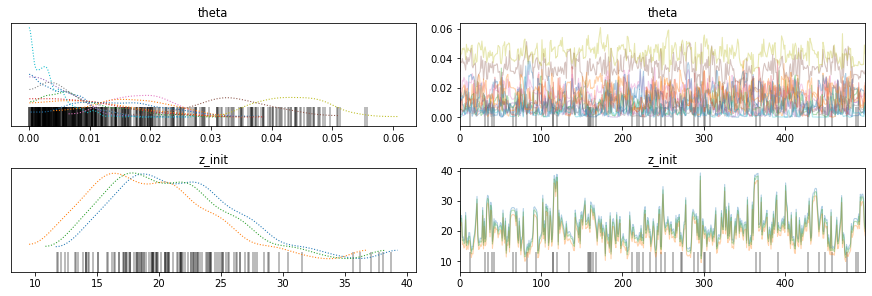

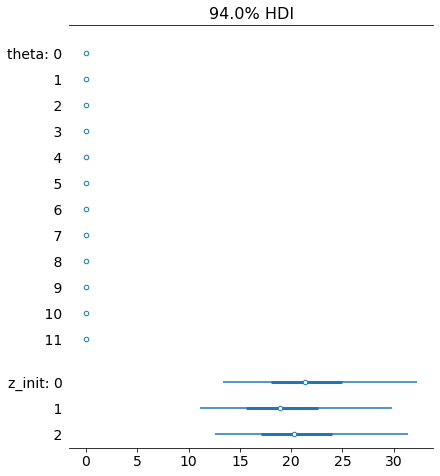

/Users/thomasmellan/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


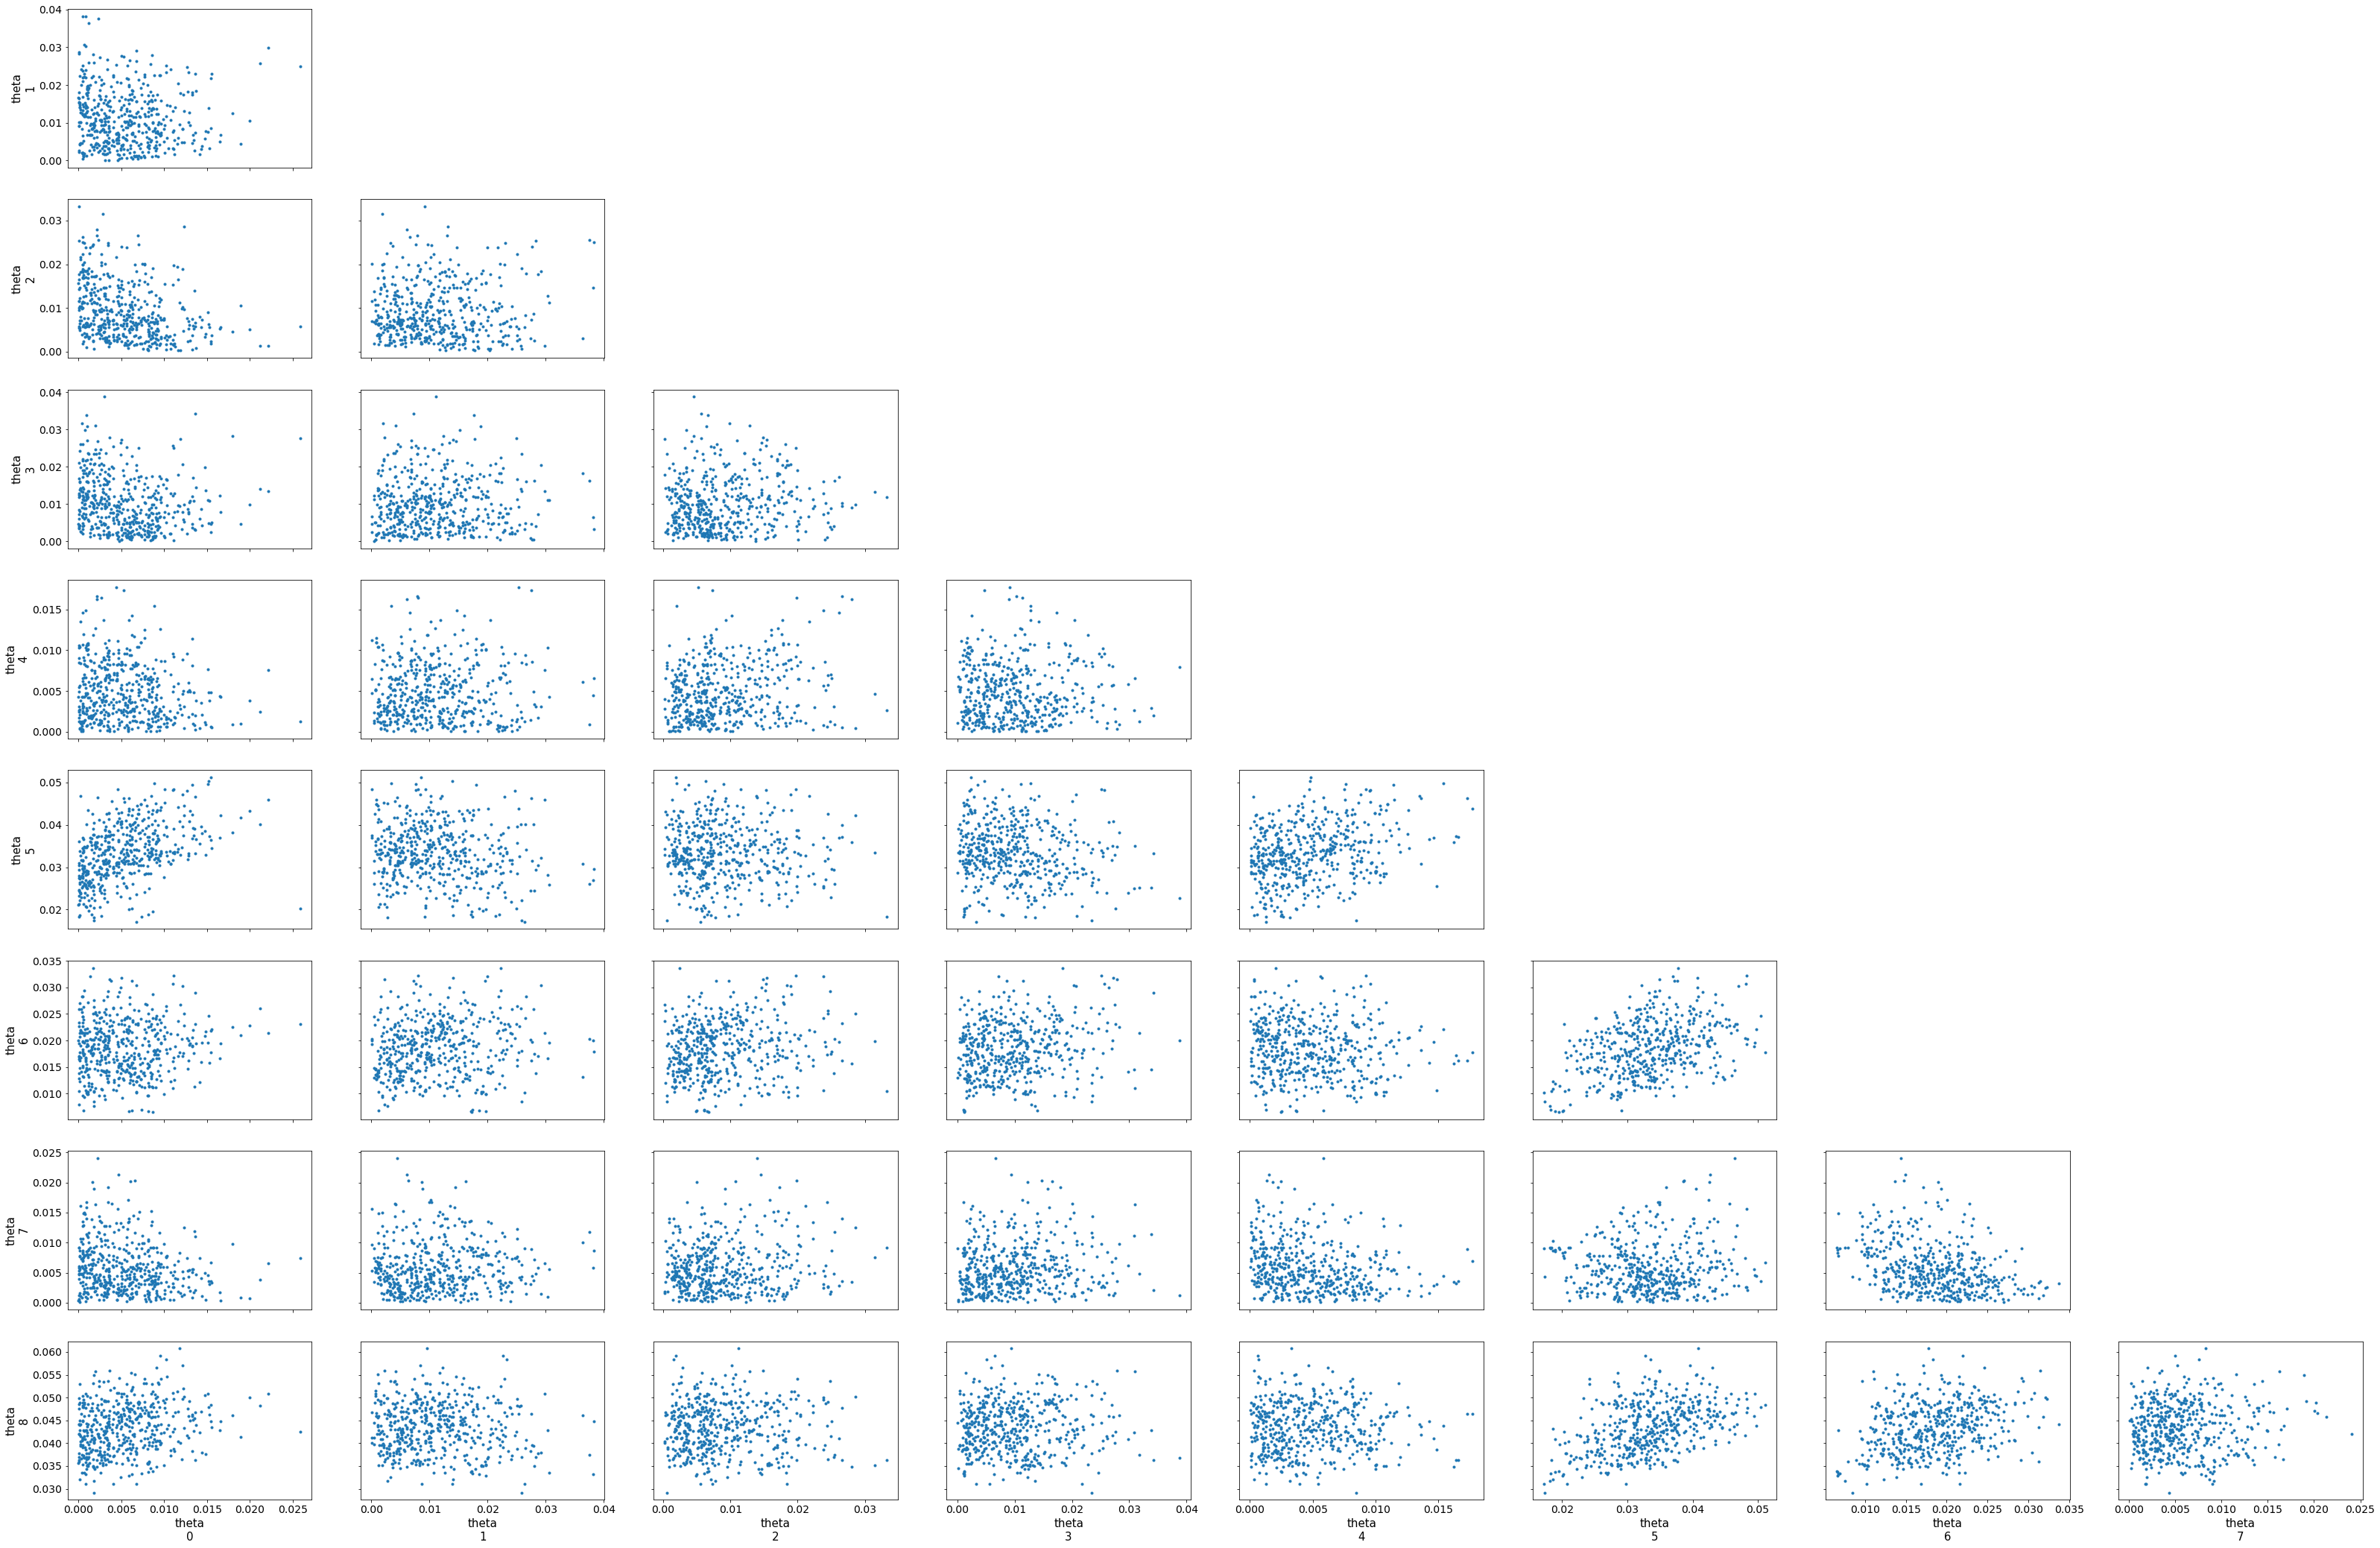

In [18]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

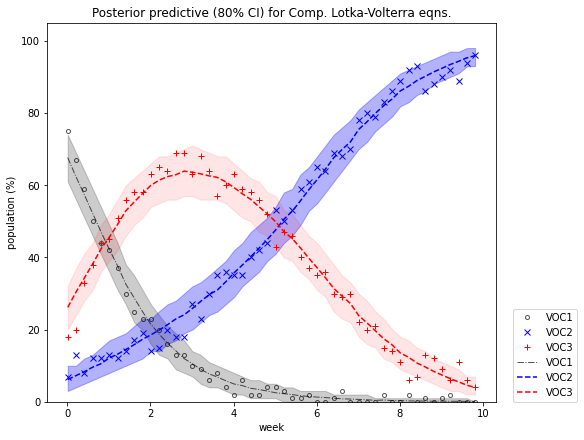

In [20]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

## 4-species

In [21]:
#Recover parameters via inference from data from mathematica simulation for 3 species:
df=pd.read_csv("../data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

# rounding fails if you have three so just need to do some sort of data massaging
trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
col12 = trans_data[...,0:2]
col4 = np.random.randint(0, 4, trans_data.shape[0])
col3 = trans_data[...,2] - col4
trans_data = np.append(col12, np.append([col3], [col4],0).T, 1)

trans_data[:5]

array([[75.,  7., 18.,  0.],
       [67., 13., 17.,  3.],
       [59.,  8., 33.,  0.],
       [50., 12., 36.,  2.],
       [44., 12., 44.,  0.]])

In [22]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior
def dz_dt(z : float, t : float , theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34, a4, a41, a42, a43, a44,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
        theta[..., 15],
        theta[..., 16],
        theta[..., 17],
        theta[..., 18],
        theta[..., 19],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = a4 * z4 * (1 - (a41 * z1 + a42 * z2 + a43 * z3 + a44 * z4))
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N : int, y = None):

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc= Sloc * jnp.repeat(1, 20),
            scale= Svar * jnp.repeat(1, 20),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs=y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 500,
    num_warmup = 500,
    num_chains = NUM_CORES,
    progress_bar = False,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00      0.00      0.01    249.64      1.02
  theta[1]      0.01      0.01      0.01      0.00      0.03    292.47      1.00
  theta[2]      0.01      0.01      0.01      0.00      0.02    195.21      1.00
  theta[3]      0.01      0.01      0.01      0.00      0.02    221.88      1.01
  theta[4]      0.01      0.01      0.01      0.00      0.02    293.92      1.00
  theta[5]      0.01      0.00      0.00      0.00      0.01    156.63      1.00
  theta[6]      0.03      0.01      0.03      0.03      0.05    166.46      1.00
  theta[7]      0.01      0.01      0.01      0.00      0.02    157.22      1.00
  theta[8]      0.01      0.00      0.01      0.00      0.01    178.38      1.00
  theta[9]      0.01      0.01      0.01      0.00      0.02    195.54      1.00
 theta[10]      0.05      0.01      0.05      0.04      0.06    147.22      1.02
 theta[11]      0.00      0

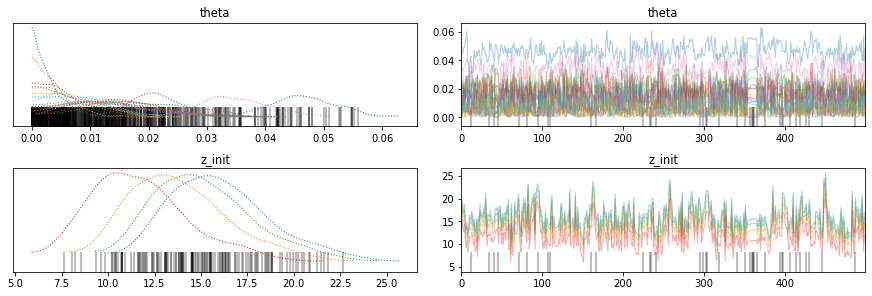

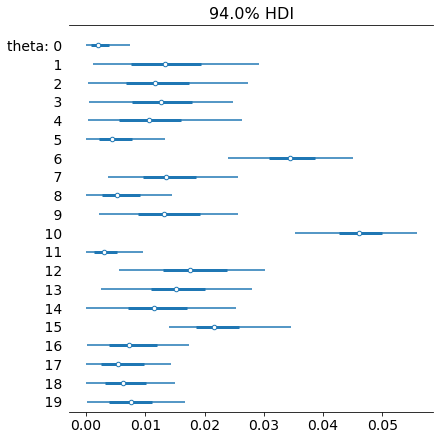

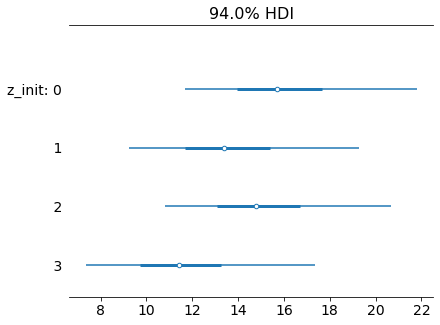

/Users/thomasmellan/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


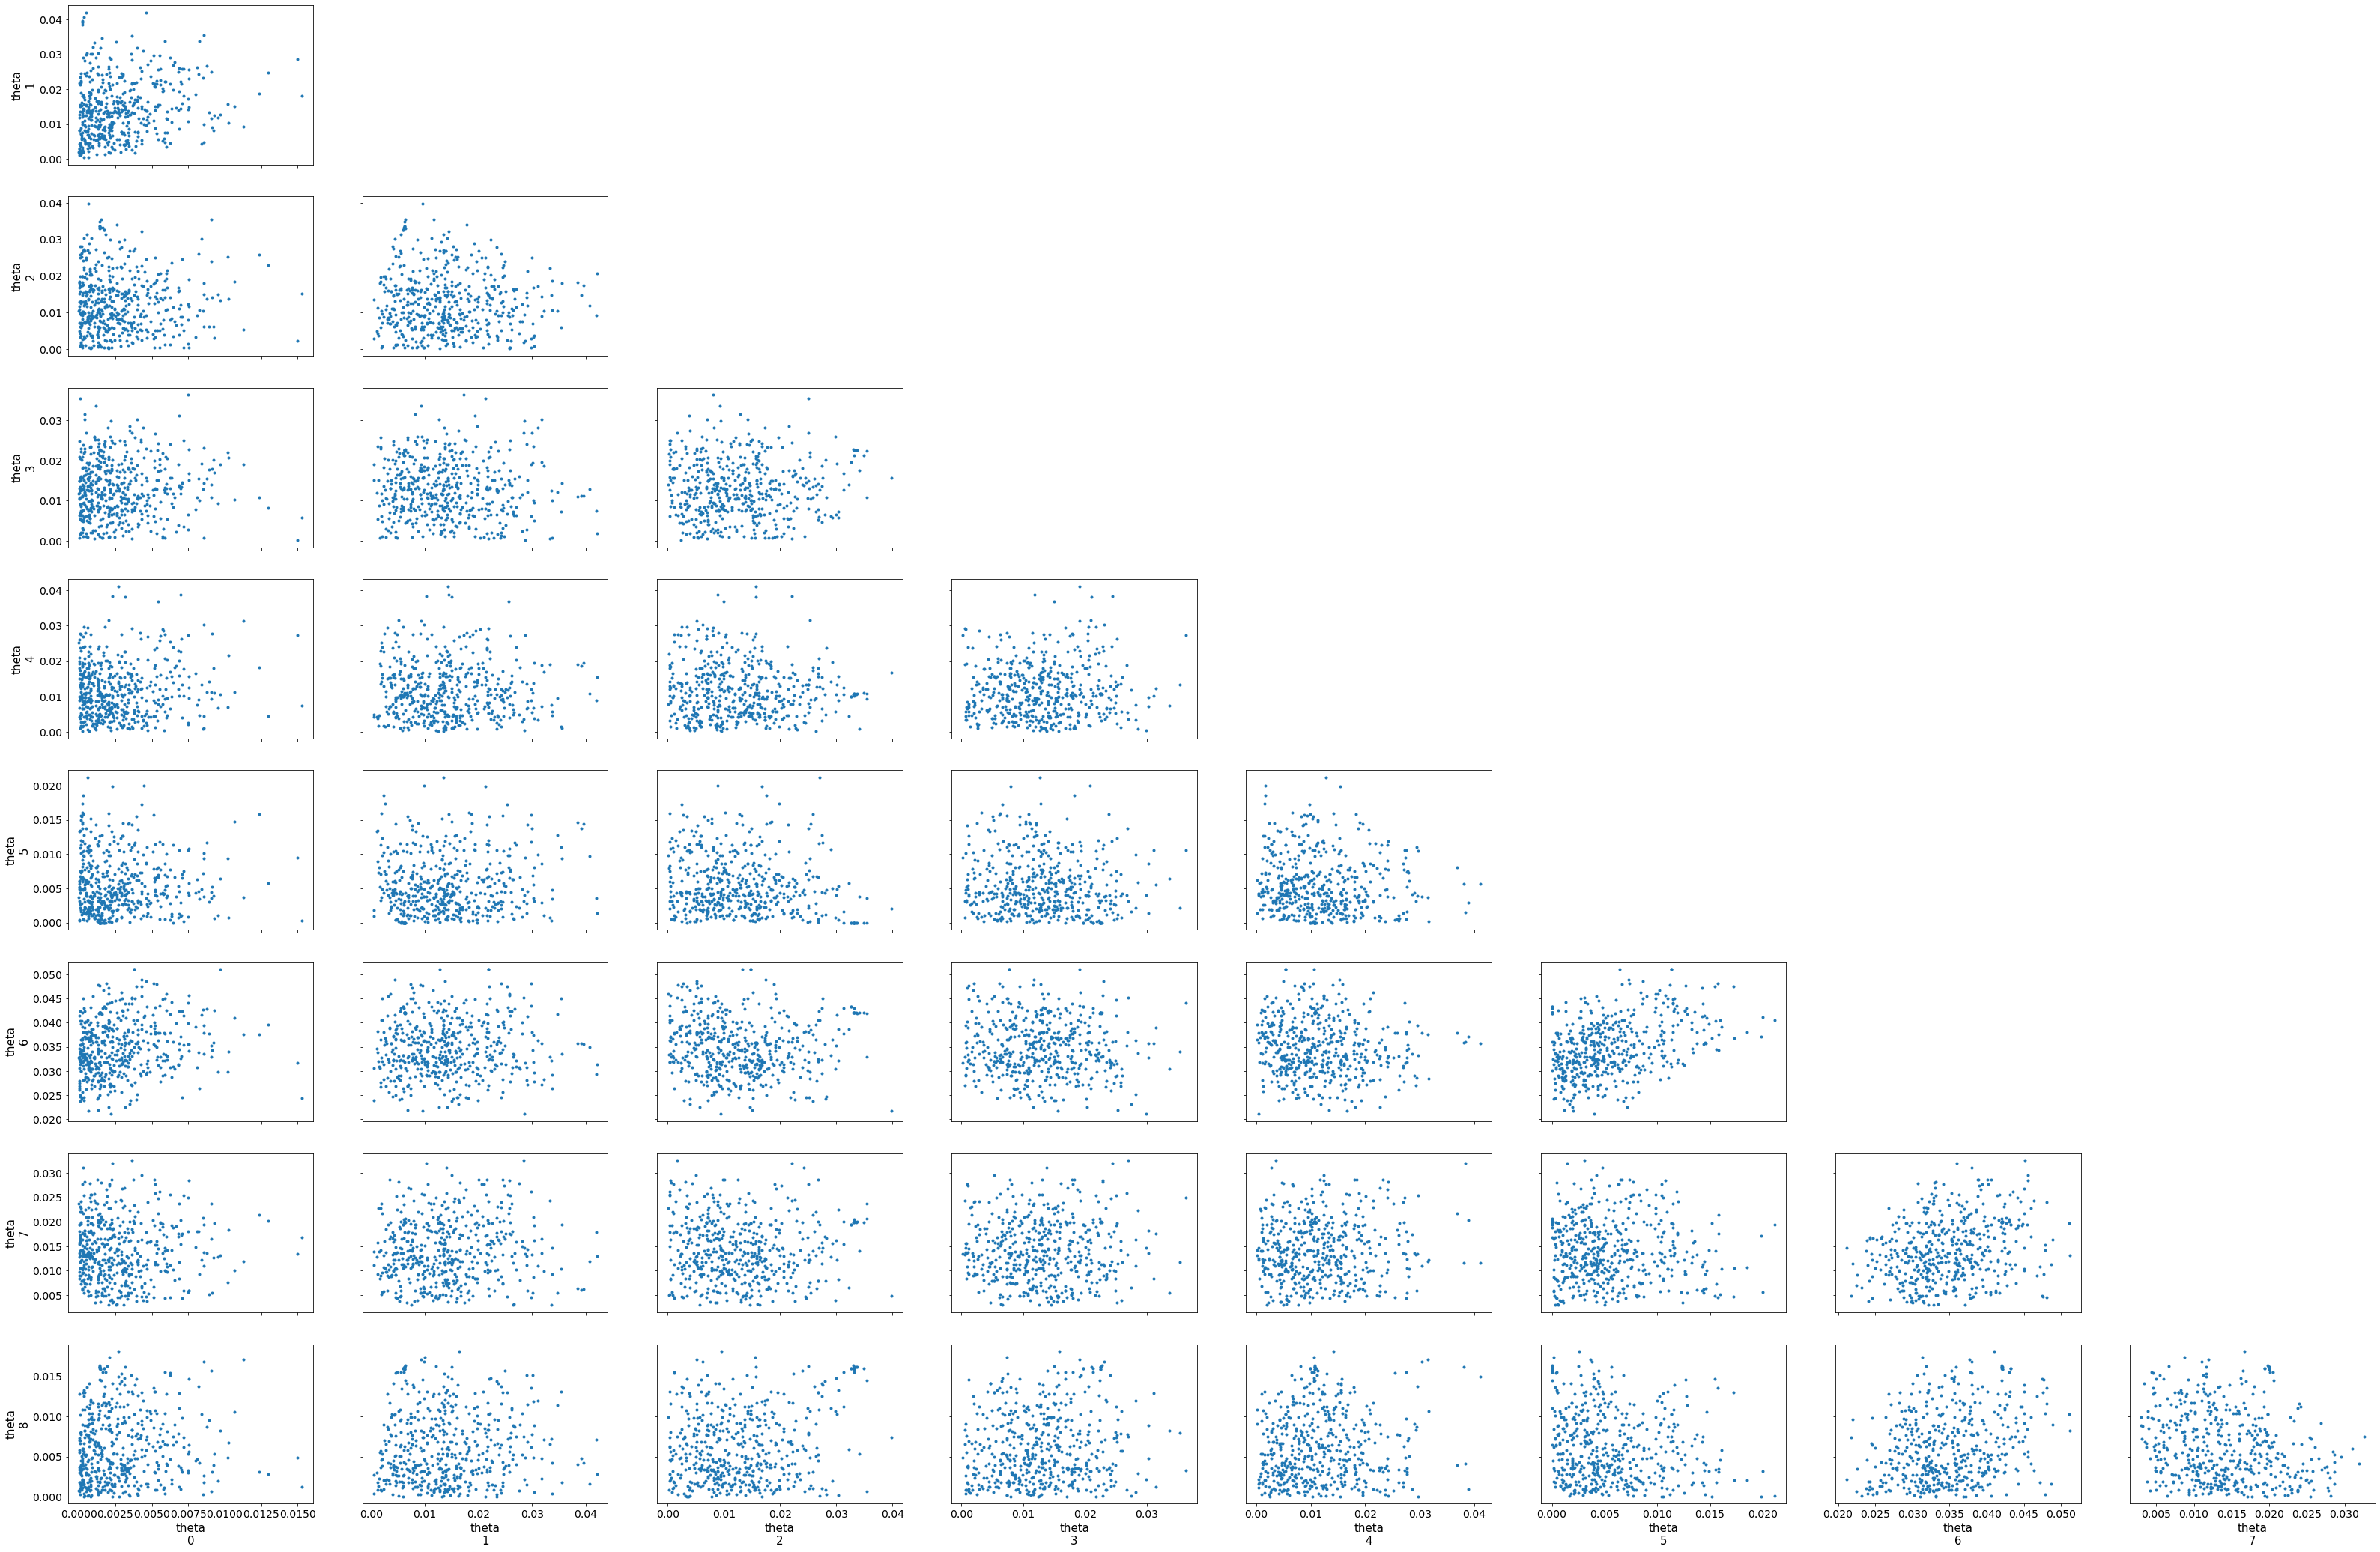

In [23]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['theta'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

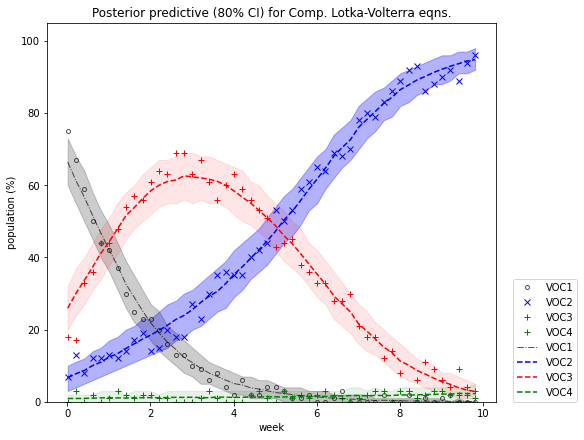

In [24]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

### Assume sum to 1 to drop 5 parameters

In [25]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior
def dz_dt(z : float, t : float , theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = - dz1_dt - dz2_dt - dz3_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N : int, y = None):

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc= Sloc * jnp.repeat(1, 15),
            scale= Svar * jnp.repeat(1, 15),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 500,
    num_warmup = 500,
    num_chains = NUM_CORES,
    progress_bar = True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()



  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:10<2:53:40, 10.43s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   4%|▍         | 39/1000 [00:10<1:56:57,  7.30s/it, 15 steps of size 2.33e-04. acc. prob=0.69]

warmup:   7%|▋         | 67/1000 [00:10<1:19:30,  5.11s/it, 7 steps of size 5.10e-05. acc. prob=0.71] 

warmup:   8%|▊         | 84/1000 [00:10<54:39,  3.58s/it, 7 steps of size 1.03e-04. acc. prob=0.73]  

warmup:  10%|█         | 101/1000 [00:10<37:35,  2.51s/it, 31 steps of size 8.68e-03. acc. prob=0.75]

warmup:  12%|█▏        | 119/1000 [00:10<25:48,  1.76s/it, 15 steps of size 1.38e-02. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [00:11<17:44,  1.23s/it, 63 steps of size 8.17e-02. acc. prob=0.77]

warmup:  15%|█▌        | 152/1000 [00:12<12:35,  1.12it/s, 1 steps of size 2.35e-02. acc. prob=0.76] 

warmup:  16%|█▋        | 164/1000 [00:14<09:19,  1.49it/s, 1023 steps of size 4.79e-03. acc. prob=0.76]

warmup:  17%|█▋        | 1

warmup:  28%|██▊       | 277/1000 [00:30<01:56,  6.23it/s, 529 steps of size 1.09e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 278/1000 [00:30<02:05,  5.76it/s, 1023 steps of size 1.98e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [00:31<02:11,  5.48it/s, 1023 steps of size 3.52e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [00:31<02:16,  5.27it/s, 1023 steps of size 5.45e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [00:31<02:19,  5.15it/s, 1023 steps of size 1.80e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [00:31<02:21,  5.07it/s, 1023 steps of size 3.19e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [00:31<02:22,  5.02it/s, 1023 steps of size 3.66e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [00:32<02:23,  4.98it/s, 1023 steps of size 6.04e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [00:32<02:02,  5.83it/s, 1023 steps of size 1.59e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [00:32<02:09,  5.49it

warmup:  37%|███▋      | 368/1000 [00:45<02:04,  5.08it/s, 1023 steps of size 3.09e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [00:45<01:39,  6.30it/s, 211 steps of size 2.50e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 371/1000 [00:46<01:47,  5.84it/s, 1023 steps of size 1.59e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [00:46<01:53,  5.54it/s, 1023 steps of size 2.23e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [00:46<01:58,  5.31it/s, 1023 steps of size 2.96e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [00:46<02:00,  5.19it/s, 1023 steps of size 1.54e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [00:47<02:02,  5.11it/s, 1023 steps of size 2.12e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [00:47<02:03,  5.06it/s, 1023 steps of size 2.64e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [00:47<02:03,  5.03it/s, 1023 steps of size 3.36e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [00:47<02:03,  5.02it

warmup:  46%|████▌     | 461/1000 [01:00<01:33,  5.77it/s, 1023 steps of size 3.79e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [01:00<01:36,  5.55it/s, 1023 steps of size 2.33e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [01:00<01:40,  5.37it/s, 1023 steps of size 4.35e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [01:01<01:41,  5.26it/s, 1023 steps of size 7.65e-04. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [01:01<01:43,  5.17it/s, 1023 steps of size 1.45e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [01:01<01:44,  5.13it/s, 1023 steps of size 2.68e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [01:01<01:44,  5.09it/s, 1023 steps of size 3.76e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [01:01<01:33,  5.66it/s, 1023 steps of size 4.19e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [01:02<01:36,  5.48it/s, 1023 steps of size 3.68e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [01:02<01:39,  5.34it

sample:  55%|█████▍    | 545/1000 [01:15<01:30,  5.02it/s, 1023 steps of size 2.90e-03. acc. prob=0.84]

sample:  55%|█████▍    | 546/1000 [01:15<01:30,  5.02it/s, 1023 steps of size 2.90e-03. acc. prob=0.84]

sample:  55%|█████▍    | 548/1000 [01:15<01:20,  5.64it/s, 1023 steps of size 2.90e-03. acc. prob=0.83]

sample:  55%|█████▍    | 549/1000 [01:15<01:23,  5.42it/s, 1023 steps of size 2.90e-03. acc. prob=0.83]

sample:  55%|█████▌    | 550/1000 [01:15<01:24,  5.32it/s, 1023 steps of size 2.90e-03. acc. prob=0.83]

sample:  55%|█████▌    | 551/1000 [01:16<01:25,  5.24it/s, 1023 steps of size 2.90e-03. acc. prob=0.83]

sample:  55%|█████▌    | 552/1000 [01:16<01:27,  5.14it/s, 1023 steps of size 2.90e-03. acc. prob=0.82]

sample:  55%|█████▌    | 553/1000 [01:16<01:28,  5.05it/s, 1023 steps of size 2.90e-03. acc. prob=0.82]

sample:  55%|█████▌    | 554/1000 [01:16<01:28,  5.02it/s, 1023 steps of size 2.90e-03. acc. prob=0.83]

sample:  56%|█████▌    | 555/1000 [01:16<01:28,  5.00it

sample:  62%|██████▏   | 620/1000 [01:29<01:02,  6.09it/s, 617 steps of size 2.90e-03. acc. prob=0.86] 

sample:  62%|██████▏   | 621/1000 [01:29<01:05,  5.77it/s, 983 steps of size 2.90e-03. acc. prob=0.86]

sample:  62%|██████▏   | 622/1000 [01:29<01:08,  5.50it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [01:30<01:11,  5.31it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [01:30<01:12,  5.18it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  62%|██████▎   | 625/1000 [01:30<01:13,  5.10it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  63%|██████▎   | 626/1000 [01:30<01:14,  5.04it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  63%|██████▎   | 627/1000 [01:30<01:14,  5.00it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  63%|██████▎   | 628/1000 [01:31<01:14,  5.00it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  63%|██████▎   | 629/1000 [01:31<01:14,  4.96it/

sample:  70%|██████▉   | 695/1000 [01:44<00:58,  5.21it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|██████▉   | 696/1000 [01:44<00:58,  5.15it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|██████▉   | 697/1000 [01:44<00:59,  5.12it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|██████▉   | 698/1000 [01:44<00:59,  5.09it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|██████▉   | 699/1000 [01:44<00:59,  5.08it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|███████   | 700/1000 [01:45<01:00,  4.95it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|███████   | 701/1000 [01:45<01:00,  4.95it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|███████   | 702/1000 [01:45<00:59,  5.00it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|███████   | 703/1000 [01:45<00:59,  5.02it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  70%|███████   | 704/1000 [01:45<00:59,  5.01it

sample:  77%|███████▋  | 770/1000 [01:58<00:46,  4.99it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [01:59<00:45,  5.00it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [01:59<00:45,  4.99it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [01:59<00:45,  4.94it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [01:59<00:45,  4.93it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [01:59<00:45,  4.96it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [02:00<00:45,  4.90it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [02:00<00:45,  4.91it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [02:00<00:44,  4.96it/s, 1023 steps of size 2.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [02:00<00:44,  4.95it

sample:  85%|████████▍ | 846/1000 [02:13<00:30,  5.01it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▍ | 848/1000 [02:13<00:25,  5.85it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▍ | 849/1000 [02:13<00:27,  5.56it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▌ | 850/1000 [02:14<00:27,  5.37it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▌ | 851/1000 [02:14<00:28,  5.24it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▌ | 852/1000 [02:14<00:28,  5.16it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▌ | 853/1000 [02:14<00:28,  5.12it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  85%|████████▌ | 854/1000 [02:14<00:28,  5.09it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  86%|████████▌ | 855/1000 [02:15<00:28,  5.07it/s, 1023 steps of size 2.90e-03. acc. prob=0.87]

sample:  86%|████████▌ | 856/1000 [02:15<00:28,  5.06it

sample:  92%|█████████▏| 922/1000 [02:28<00:15,  5.02it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  92%|█████████▏| 923/1000 [02:28<00:17,  4.45it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  92%|█████████▏| 924/1000 [02:28<00:17,  4.44it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  92%|█████████▎| 925/1000 [02:29<00:16,  4.43it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 927/1000 [02:29<00:14,  5.15it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 928/1000 [02:29<00:14,  4.81it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 929/1000 [02:29<00:14,  4.78it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 931/1000 [02:30<00:12,  5.40it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 932/1000 [02:30<00:12,  5.26it/s, 1023 steps of size 2.90e-03. acc. prob=0.86]

sample:  93%|█████████▎| 934/1000 [02:30<00:11,  5.99it


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.02      0.01      0.02      0.01      0.03    122.12      1.04
  theta[1]      0.03      0.01      0.03      0.02      0.04    127.67      1.01
  theta[2]      0.01      0.01      0.01      0.00      0.02     37.98      1.02
  theta[3]      0.02      0.01      0.02      0.01      0.03     84.09      1.01
  theta[4]      0.01      0.01      0.01      0.00      0.02     37.97      1.09
  theta[5]      0.01      0.00      0.01      0.00      0.02     16.42      1.05
  theta[6]      0.01      0.00      0.01      0.01      0.02     29.08      1.02
  theta[7]      0.01      0.01      0.01      0.00      0.02     32.80      1.03
  theta[8]      0.01      0.01      0.01      0.00      0.02     29.15      1.08
  theta[9]      0.01      0.01      0.01      0.00      0.02     52.11      1.06
 theta[10]      0.05      0.01      0.05      0.04      0.06    299.41      1.02
 theta[11]      0.00      0

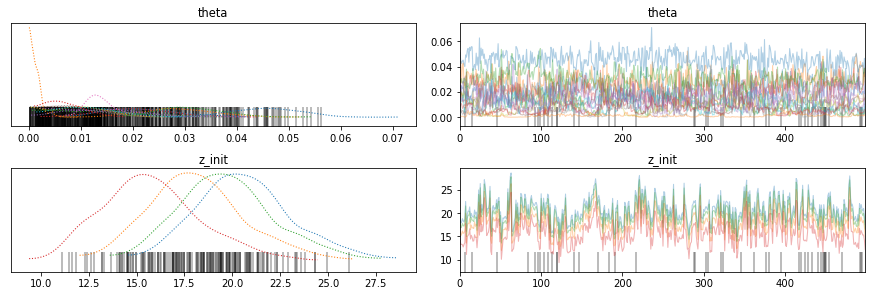

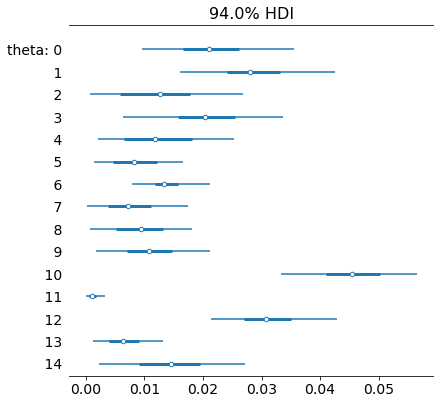

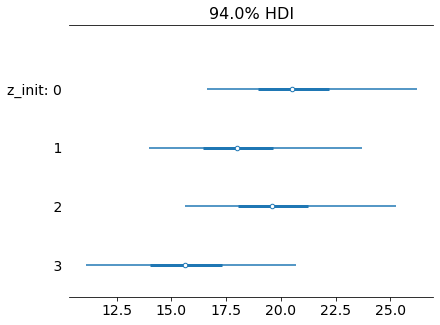

/Users/thomasmellan/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


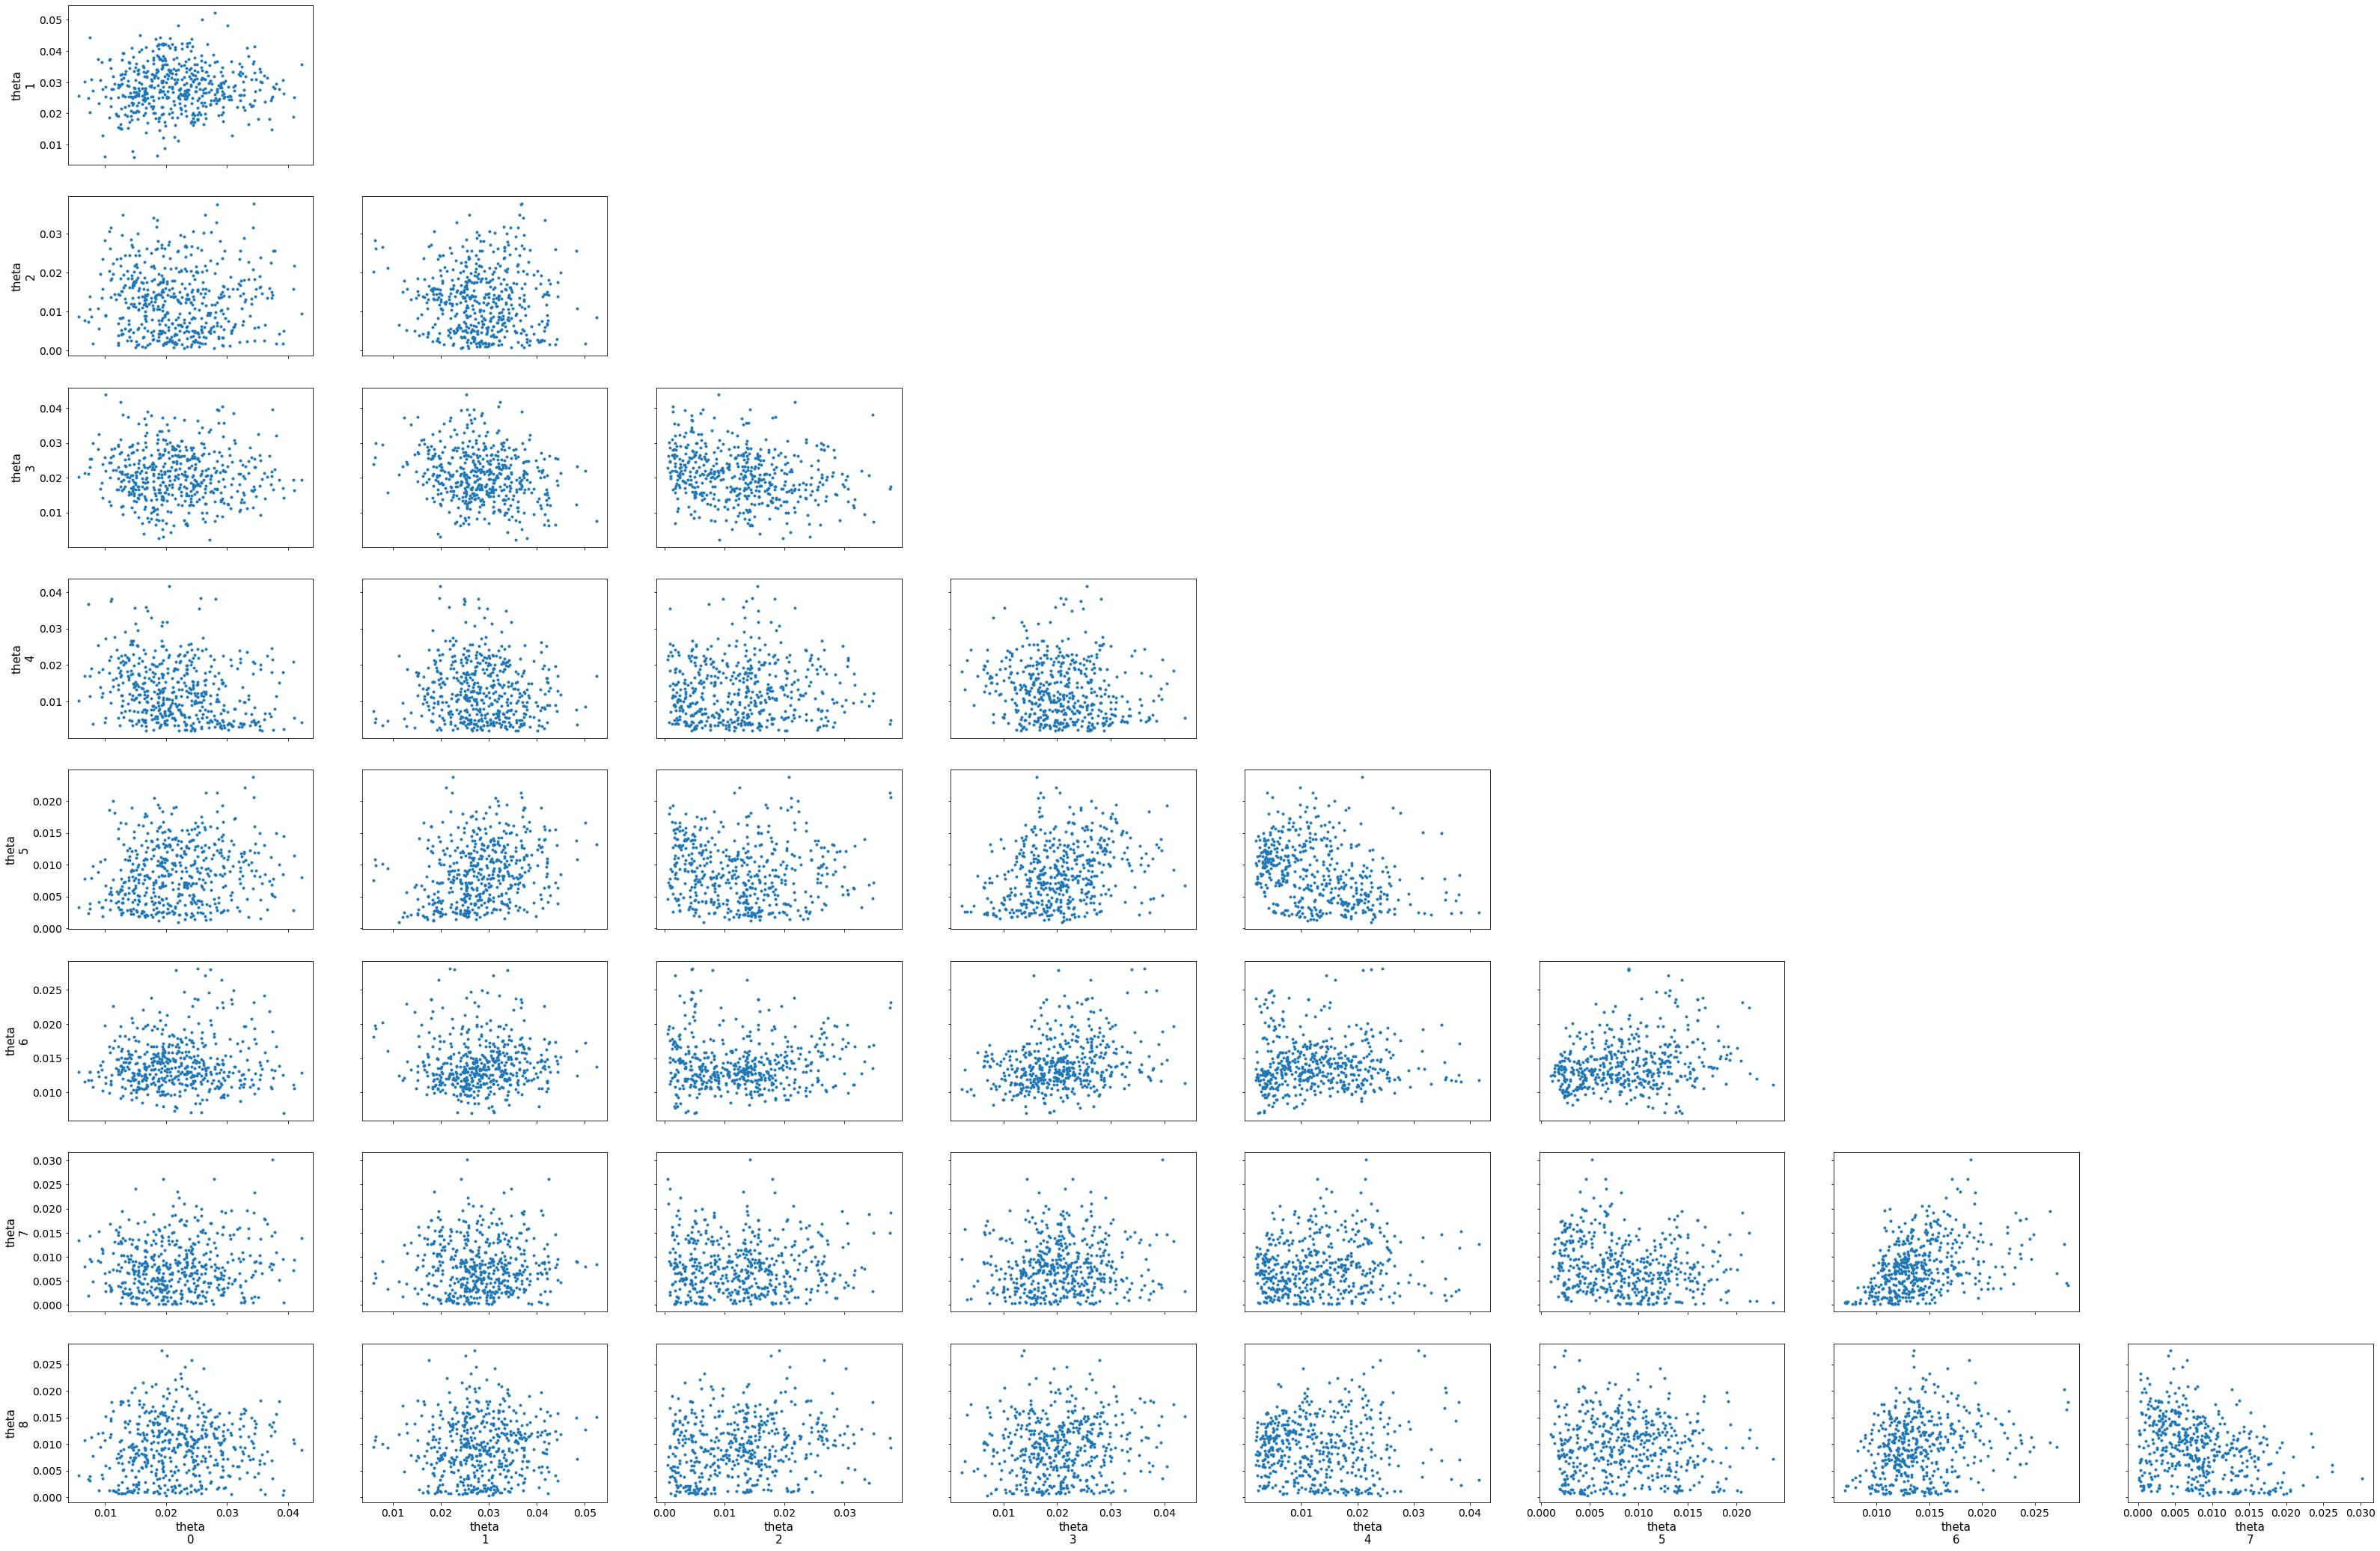

In [26]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['theta'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

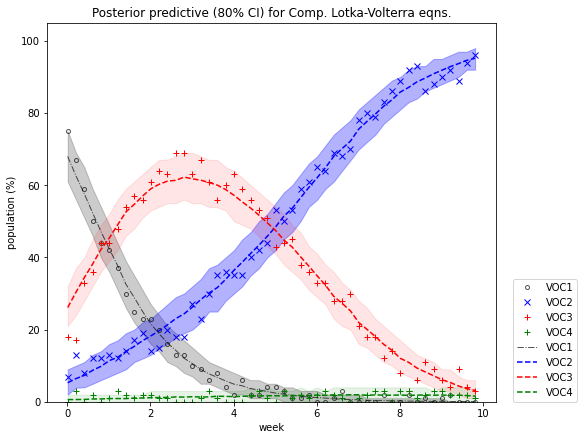

In [27]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()